Function description:

1. Select appropriate list of blobs from gcp fs, most recent hour's worth of data from GOES MCMIPC bucket. This should be 12 blobs because there are scans every 5 mins.
2. Download the set of blobs, pruning unneeded data such as data quality flag arrays and unused bands, return list of data sets
3. Concatenate the 12 datasets into one, effectively creating a dataset with a time dimension
4. Take median over the time dimension, so each pixel has median value of the last hour for each band
5. Feature engineer the median dataset, adding more informative bands that are ratios of the spectral channels
6. Reproject this dataset to epsg 4326
7. Download the preprocessed landfire layers. These have been reproject_matched to a GOES CONUS 'template' image, which has itself been reprojected to epsg 4326. This is intended to match the slightly convoluted preprocessing routine of training data the pytorch model was trained on.
8. Stack the GOES ds with the preprocessed landfire layers into a dataset.
9. Chunk the stacks to pytorch manageable size and upload to a bucket, this will be a large list of dataset files that have the stacked raster imagery with metadata that can be used to project pytorch container's inference.




In [1]:
from google.cloud import storage
from datetime import datetime, timedelta
import pandas as pd
import rioxarray
import xarray as xr
import numpy as np
import fsspec
import os
import tempfile
import zipfile


In [29]:
def select_blobs(bucket_name='gcp-public-data-goes-16'):
    """
    Selects the appropriate list of blobs from GCP fs, most recent hour's worth of data from GOES MCMIPC bucket.
    Returns: List of selected blobs.
    """
    # Get the current time
    attime = datetime.utcnow()

    # Set up Google Cloud Storage client
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)

    # Create a range of directories to check. The GOES bucket is
    # organized by hour of day.
    selected_blobs = []
    for i in range(2):  # Get blobs from current hour and previous hour
        current_time = attime - timedelta(hours=i)
        prefix = f'ABI-L2-MCMIPC/{current_time.year}/{current_time.timetuple().tm_yday:03d}/{current_time.hour:02d}/'
        blobs = bucket.list_blobs(prefix=prefix)
        selected_blobs.extend([blob.name for blob in blobs])

    # Sort the blobs by their timestamp in descending order
    selected_blobs.sort(key=lambda name: name.split('_')[3][1:], reverse=True)

    # Check if there are at least 12 blobs
    if len(selected_blobs) < 12:
        raise Exception(f"Only {len(selected_blobs)} blobs found")

    return selected_blobs[:12]


def create_fs():
    """
    Creates a file system object for GCP. 
    Returns: File system object. fs can be interacted with as though it were a local file system.
    """
    fs = fsspec.filesystem('gcs', token=os.environ['GOOGLE_APPLICATION_CREDENTIALS'])
    return fs


def create_median_image(blob_list, fs, bucket_name='gcp-public-data-goes-16'):
    """
    This function creates a single-band image from a list of blob names.
    The pixel values in the image are the median values from the corresponding pixels in the input images.
    """
    # Initialize a list to store the Datasets
    datasets = []

    # Open each blob as a full dataset and load it into memory
    for blob in blob_list[4::]:  # Use every 6th blob for testing purposes (faster operation creating each median without pipeline-structure difference), change to 1 later
        f = fs.open(f'{bucket_name}/{blob}')
        print(f'Opening: {bucket_name}/{blob}')
        ds = xr.open_dataset(f).load()

        # Select a firey region for testing - large NW US region
        ds = ds.isel(x=slice(0, 1250), y=slice(0, 1250))

        datasets.append(ds)

    # Concatenate the datasets along a new 'band' dimension
    concated = xr.concat(datasets, dim='time')

    # Compute the median along the 'band' dimension
    median_ds = concated.median(dim='time', keep_attrs=True)

    # Close the files
    for ds in datasets:
        ds.close()

    # Return the median dataset
    return median_ds

def download_landfire_layers(fs, bucket_name='firenet_reference', blob_name='combined_landfire.nc'):
    """
    Downloads the preprocessed landfire layers. These have been reproject_matched to a GOES CONUS 'template' image, 
    which has itself been reprojected to epsg 5070. Properly loading and accessing the spatial metadata uses a
    trick, openning with xarray, saving to nc, then opening the nc tempfile with rioxarray. This is not a "good"
    approach but for whatever reason the spatial metadata couldn't be accessed otherwise. Trying to open directly with
    rioxarray runs into some interfacing problem with google buckets.
    Returns: Preprocessed landfire layers.
    """

    # Open the blob as a full dataset and load it into memory
    f = fs.open(f'{bucket_name}/{blob_name}')
    print(f'Opening: {bucket_name}/{blob_name}')
    ds = xr.open_dataset(f).load()

    # Create a temporary file
    with tempfile.NamedTemporaryFile(suffix='.nc') as tmpfile:
        # Save the dataset to the temporary file
        ds.to_netcdf(tmpfile.name)

        # Open the temporary file with rioxarray
        landfire_layers = rioxarray.open_rasterio(tmpfile.name)

    return landfire_layers

def reproject_dataset(dataset, landfire_layers):
    """
    Reprojects the dataset to the static layers.
    Note that the technique used here is again creating a tempfile and then opening it with rioxarray.
    This is not a "good" approach but for whatever reason the spatial metadata couldn't be accessed otherwise.
    Trying to open directly with rioxarray runs into some interfacing problem with google buckets.
    Returns: Reprojected dataset.
    """
    # Create a temporary file
    with tempfile.NamedTemporaryFile(suffix='.nc') as tmpfile:
        # Save the dataset to the temporary file
        dataset.to_netcdf(tmpfile.name)

        # Open the temporary file with rioxarray
        ds_rio = rioxarray.open_rasterio(tmpfile.name)
        
        # Reproject the dataset to the template dataset with landfire layers, landfire layers was generated by
        #  `reprojectmatch_and_stack_landfire_for_bucket.ipynb`
        reprojected_dataset = ds_rio.rio.reproject_match(landfire_layers)

    return reprojected_dataset

def engineer_features(dataset):
    """
    Feature engineers the median dataset, adding more informative bands that are ratios of the spectral channels.
    Returns: Feature engineered dataset.
    """

    vars_to_remove = [f for f in dataset.keys() if f.startswith('DQF_')]
    dataset = dataset.drop_vars(vars_to_remove)
    # Ensure the CRS is preserved by extracting it from the original dataset
    original_crs = dataset.rio.crs

    # Compute the new features
    feat1 = dataset['CMI_C06'] / dataset['CMI_C05']
    feat2 = dataset['CMI_C07'] / dataset['CMI_C05']
    feat3 = dataset['CMI_C07'] / dataset['CMI_C06']
    feat4 = dataset['CMI_C14'] / dataset['CMI_C07']

    # Create a dictionary of the new features
    data_dict = {'feat_6_5': feat1, 'feat_7_5': feat2, 'feat_7_6': feat3, 'feat_14_7': feat4}

    # Add the new features to the dataset
    engineered_dataset = dataset.assign(data_dict)

    # Write the CRS of original_dataset to engineered_dataset, as a global attribute
    engineered_dataset.rio.write_crs(original_crs, inplace=True)

    # Write the CRS to every variable in engineered_dataset, making all var attrs match
    for var in engineered_dataset.data_vars:
        engineered_dataset[var].rio.write_crs(original_crs, inplace=True)

    return engineered_dataset

def stack_datasets(goes_ds, landfire_layers):
    """
    Stacks the GOES ds with the preprocessed landfire layers into a dataset.
    Sets 'grid_mapping' to 'spatial_ref' in the encoding for every data variable in the process.
    Returns: Stacked dataset.
    """
    # Merge the two datasets
    stacked_dataset = xr.merge([goes_ds, landfire_layers])

    # Set 'grid_mapping' to 'spatial_ref' in the encoding dictionary for every data variable
    # Pointing this encoding key to the global spatial_ref value is vital to ensure spatial metadata
    # Gets recognized by future rioxarray and other operations
    for var in stacked_dataset.data_vars:
        stacked_dataset[var].encoding['grid_mapping'] = 'spatial_ref'

    # Optionally, delete 'goes_imager_projection' if it's no longer needed
    if 'goes_imager_projection' in stacked_dataset:
        del stacked_dataset['goes_imager_projection']

    return stacked_dataset

def prune_dataset(ds):
    """
    Drops specified data variables from the dataset.
    #TODO make sure the indices to drop match perfectly the original training

    Parameters:
    - ds: xarray.Dataset to be pruned.
    - vars_to_drop: List of strings representing the names of the variables to drop.

    Returns:
    - ds: xarray.Dataset after dropping the specified variables.
    """
    # Drop the specified variables from the dataset
    var_names_to_drop = [list(ds.data_vars)[i] for i in [0, 11, 16, 17, 18]]

    ds = ds.drop_vars(var_names_to_drop)
    
    return ds

def create_spatial_template(dataset):
    """
    Creates a spatial template from the original dataset by keeping only one data variable
    and setting its values to 0, while preserving spatial metadata. This step allows us to
    Take the datavars out as a 21x64x64 numpy array, then add the model output back as 1x64x64
    so that the spatial projection of the output is untouched.
    
    Parameters:
    - dataset: xarray.Dataset or rioxarray object with spatial dimensions and CRS information.
    
    Returns:
    - template: xarray.Dataset with a single data variable filled with NaNs and original spatial metadata.
    """
    # Clone the dataset to avoid modifying the original
    template = dataset.copy()
    
    # Select the first data variable (assuming there's at least one)
    first_var_name = list(template.data_vars)[0]
    first_var = template[first_var_name]
    
    # Create a 0-filled template of the first variable
    nan_template = xr.full_like(first_var, fill_value=np.nan)
    
    # Remove all data variables from the template
    for var_name in list(template.data_vars):
        del template[var_name]
    
    # Add the NaN-filled template variable back
    template[first_var_name] = nan_template
    
    # Ensure the spatial metadata is preserved
    # Note: This step might be redundant if the metadata is already attached to the coordinates
    # and not the data variables themselves. However, it's a safeguard for maintaining CRS.
    if hasattr(dataset, 'rio') and hasattr(dataset.rio, 'crs'):
        template.rio.write_crs(dataset.rio.crs, inplace=True)
    
    return template

def extract_data_as_array(dataset):
    """
    This function pulls the data variable value arrays out of the xarray dataset.
    """
    # Stack the data variables, then use np.squeeze() to remove the singleton dimension that was a placeholder for time.
    # The resultant array should be the shape 42, 3506, 2266. The second two dimensions may change if region of interest changes.

    stacked_array = np.stack([dataset[var].values for var in dataset.data_vars], axis=0)
    squeezed_array = np.squeeze(stacked_array)
    return squeezed_array

def chunk_ndarray(arr, chunk_size=64):
    """
    Breaks down an N-dimensional array into chunks along the last two dimensions,
    keeping the first dimension intact in each chunk.
    
    Parameters:
    - arr: Input N-dimensional NumPy array with shape (Variables, Height, Width).
    - chunk_size: Size of the chunks along each of the last two dimensions.
    
    Returns:
    - A list of chunks, where each chunk is an N-dimensional NumPy array with shape (Variables, chunk_size, chunk_size).
    """
    chunks = []
    # Iterate over the last two dimensions in steps of `chunk_size`
    for i in range(0, arr.shape[1], chunk_size):  # Height dimension
        for j in range(0, arr.shape[2], chunk_size):  # Width dimension
            # Calculate the end indices while ensuring they do not exceed the array's dimensions
            end_i = min(i + chunk_size, arr.shape[1])
            end_j = min(j + chunk_size, arr.shape[2])
            # Extract the chunk
            chunk = arr[:, i:end_i, j:end_j]
            # Only add chunks that meet the full size requirement (i.e., 42x64x64)
            if chunk.shape[1] == chunk_size and chunk.shape[2] == chunk_size:
                chunks.append(chunk)
    return chunks

def process_chunks(chunks):
    # Example operation: sum along the first axis (simulating adding arrays together
    # Once we get neural net into this spot, returning the 1x64x64 arrays we should be good
    return np.average(chunks, axis=1)

def stitch_chunks(processed_chunks, original_shape):
    # Assuming processed_chunks is a list of 2D arrays (Height, Width)
    # and original_shape is the shape of the 2D plane of the original array (Height, Width)
    stitched = np.zeros(original_shape)
    chunk_size = processed_chunks[0].shape[0]
    for k, chunk in enumerate(processed_chunks):
        i, j = divmod(k, original_shape[1] // chunk_size)
        stitched[i*chunk_size:(i+1)*chunk_size, j*chunk_size:(j+1)*chunk_size] = chunk
    return stitched

In [3]:
selected_blobs = select_blobs()


In [4]:

fs = create_fs()
median_ds = create_median_image(selected_blobs, fs)

Opening: gcp-public-data-goes-16/ABI-L2-MCMIPC/2024/035/22/OR_ABI-L2-MCMIPC-M6_G16_s20240352246176_e20240352248555_c20240352249075.nc
Opening: gcp-public-data-goes-16/ABI-L2-MCMIPC/2024/035/22/OR_ABI-L2-MCMIPC-M6_G16_s20240352241176_e20240352243555_c20240352244074.nc
Opening: gcp-public-data-goes-16/ABI-L2-MCMIPC/2024/035/22/OR_ABI-L2-MCMIPC-M6_G16_s20240352236176_e20240352238561_c20240352239079.nc
Opening: gcp-public-data-goes-16/ABI-L2-MCMIPC/2024/035/22/OR_ABI-L2-MCMIPC-M6_G16_s20240352231176_e20240352233555_c20240352234064.nc
Opening: gcp-public-data-goes-16/ABI-L2-MCMIPC/2024/035/22/OR_ABI-L2-MCMIPC-M6_G16_s20240352226176_e20240352228549_c20240352229063.nc
Opening: gcp-public-data-goes-16/ABI-L2-MCMIPC/2024/035/22/OR_ABI-L2-MCMIPC-M6_G16_s20240352221176_e20240352223555_c20240352224079.nc
Opening: gcp-public-data-goes-16/ABI-L2-MCMIPC/2024/035/22/OR_ABI-L2-MCMIPC-M6_G16_s20240352216176_e20240352218549_c20240352219072.nc
Opening: gcp-public-data-goes-16/ABI-L2-MCMIPC/2024/035/22/OR_

In [16]:
landfire_layers = download_landfire_layers(fs)
reprojected_median_ds = reproject_dataset(median_ds, landfire_layers)


Opening: firenet_reference/combined_landfire.nc


/var/folders/53/g51yyrxd1gx8s6s6n03zzjbh0000gn/T/ipykernel_34838/1634161742.py:109: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  dataset.to_netcdf(tmpfile.name)
/var/folders/53/g51yyrxd1gx8s6s6n03zzjbh0000gn/T/ipykernel_34838/1634161742.py:109: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  dataset.to_netcdf(tmpfile.name)


In [25]:

reprojected_median_ds = engineer_features(reprojected_median_ds)



In [30]:
stacked_ds = stack_datasets(reprojected_median_ds, landfire_layers)
stacked_ds = prune_dataset(stacked_ds)

In [31]:
stacked_ds

<xarray.Dataset>
Dimensions:        (band: 1, x: 2266, y: 3506)
Coordinates:
  * band           (band) int64 1
  * x              (x) float64 -2.35e+06 -2.349e+06 ... -1.501e+06 -1.5e+06
  * y              (y) float64 3.159e+06 3.159e+06 ... 1.845e+06 1.845e+06
    spatial_ref    int64 0
Data variables: (12/21)
    CMI_C06        (band, y, x) float32 0.07889 0.07889 ... 0.1483 0.1483
    CMI_C07        (band, y, x) float32 270.6 270.6 270.6 ... 270.8 271.1 271.1
    CMI_C08        (band, y, x) float32 228.7 228.7 228.7 ... 231.4 232.1 232.1
    CMI_C09        (band, y, x) float32 234.6 234.6 234.6 ... 235.8 236.8 236.8
    CMI_C10        (band, y, x) float32 240.4 240.4 240.4 ... 238.1 239.3 239.3
    CMI_C11        (band, y, x) float32 259.7 259.7 259.7 ... 242.7 243.6 243.6
    ...             ...
    LC22_CBD_220   (band, y, x) int16 ...
    LC22_EVH_220   (band, y, x) int16 ...
    LC20_Elev_220  (band, y, x) int16 ...
    LC22_EVC_220   (band, y, x) int16 ...
    LC22_FVH_220   (band, y, x) int16 ...
    LC22_F40_220   (band, y, x) int16 ...
Attributes: (12/30)
    cdm_data_type:             Image
    Conventions:               CF-1.7
    coordinates:               band_id_C01 band_id_C02 band_id_C03 band_id_C0...
    dataset_name:              OR_ABI-L2-MCMIPC-M6_G16_s20240352246176_e20240...
    date_created:              2024-02-04T22:49:07.5Z
    id:                        b598a5de-5128-4f71-b3f5-06c45d052fdd
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    summary:                   Multiple reflectance and emissive channel Clou...
    timeline_id:               ABI Mode 6
    time_coverage_end:         2024-02-04T22:48:55.5Z
    time_coverage_start:       2024-02-04T22:46:17.6Z
    title:                     ABI L2 Cloud and Moisture Imagery

In [32]:
print(list(stacked_ds.keys()))

['CMI_C06', 'CMI_C07', 'CMI_C08', 'CMI_C09', 'CMI_C10', 'CMI_C11', 'CMI_C12', 'CMI_C13', 'CMI_C14', 'CMI_C15', 'CMI_C16', 'CMI_C03', 'CMI_C04', 'CMI_C05', 'feat_14_7', 'LC22_CBD_220', 'LC22_EVH_220', 'LC20_Elev_220', 'LC22_EVC_220', 'LC22_FVH_220', 'LC22_F40_220']


In [33]:
# Assuming 'ds' is your original xarray.Dataset
template = create_spatial_template(stacked_ds)
npy_array = extract_data_as_array(stacked_ds)
npy_array.shape

(21, 3506, 2266)

In [34]:

chunks = chunk_ndarray(npy_array)

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import fsspec
from xarray.backends import NetCDF4DataStore
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np

In [36]:

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class Unet(nn.Module):
    def __init__(self, in_channels, classes):
        super(Unet, self).__init__()
        self.n_channels = in_channels
        self.n_classes =  classes

        self.inc = InConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [37]:
class Fire_Dataset(torch.utils.data.Dataset):
    def __init__(self, root, mode="train", transform=None):

        assert mode in {"train", "valid", "test"}

        self.root = root
        self.mode = mode
        self.transform = transform

        self.images_directory = os.path.join(self.root, "images")
        self.masks_directory = os.path.join(self.root, "annotations")
 
        self.filenames = self._get_files(suffix = '.npy')  # read train/valid/test splits

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):

        filename = self.filenames[idx]
        
        image_path = os.path.join(self.images_directory, filename)
        mask_path = os.path.join(self.masks_directory, filename)
        
        image = torch.from_numpy(np.load(image_path))
        mask = torch.from_numpy(np.load(mask_path))
        
        sample = dict(image = image, mask = mask)
        
        

        return sample


    def _get_files(self, suffix):
        files = []
        
        if self.mode == 'train':
            dir_to_walk = os.path.join(self.root, 'images')
        elif self.mode == 'valid':
            dir_to_walk = os.path.join(self.root, 'annotations')
            
            
        for r,d,f in os.walk(dir_to_walk):
            for file in f:
                if file.endswith(suffix):
                    files.append(os.path.join(r,file))
        
        
        if self.mode == "train":  # 90% for train
            filenames = [x for i, x in enumerate(files) if i % 10 != 0]
        elif self.mode == "valid":  # 10% for validation
            filenames = [x for i, x in enumerate(files) if i % 10 == 0]

        filenames = [f.split('/')[-1] for f in filenames]
        return filenames
    
    def return_files(self):
        return self.filenames
    
    def _normalize(tensor):
        mean, std, var = torch.mean(tensor), torch.std(tensor), torch.var(tensor)

        return (tensor-mean)/std

In [38]:
def dice_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

def dice_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

In [39]:

# Load the model
unet = Unet(21, 1)
unet.load_state_dict(torch.load('/Users/adamhunter/Documents/school projs/firenet/data/model2.pt'))


<All keys matched successfully>

In [40]:
def normalize_bands(np_arr):
    """
    Normalizes each band in a 3D array independently.
    
    Parameters:
    - np_arr: A 3D NumPy array of shape (bands, height, width).
    
    Returns:
    - A 3D NumPy array of the same shape, with each band normalized.
    """
    normalized = np.zeros_like(np_arr, dtype=np.float32)
    for i in range(np_arr.shape[0]):
        band = np_arr[i]
        mini, maxi = np.min(band), np.max(band)
        if maxi != mini:
            normalized[i] = (band - mini) / (maxi - mini)
        else:
            normalized[i] = band  # If the band is constant
    return normalized

In [41]:
# Assuming `chunks` is a list of your 3D arrays (21x64x64)
for chunk in chunks:
    # Normalize the current chunk
    normalized_chunk = normalize_bands(chunk)
    
    # Convert the normalized chunk to a PyTorch tensor
    input_data = torch.from_numpy(normalized_chunk).float()
    
    # Add a batch dimension, just to fit with the model this is a singleton
    input_data = input_data.unsqueeze(0)
    
    # Now, input_data is ready to be fed into the U-Net model
    predictions = unet(input_data)
    
    # Process the predictions as needed

In [54]:
predictions[0].detach().numpy().shape

(1, 64, 64)

In [53]:
npy_array.shape

(21, 3506, 2266)

In [55]:

stitched = stitch_chunks(predictions.detach().numpy().squeeze(), npy_array.shape[-2:])
stitched.shape

(3506, 2266)

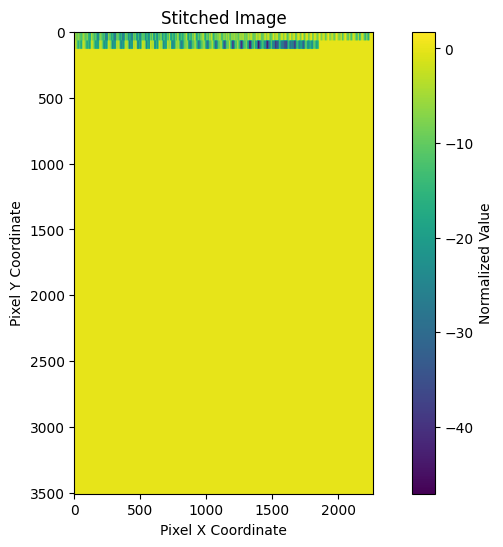

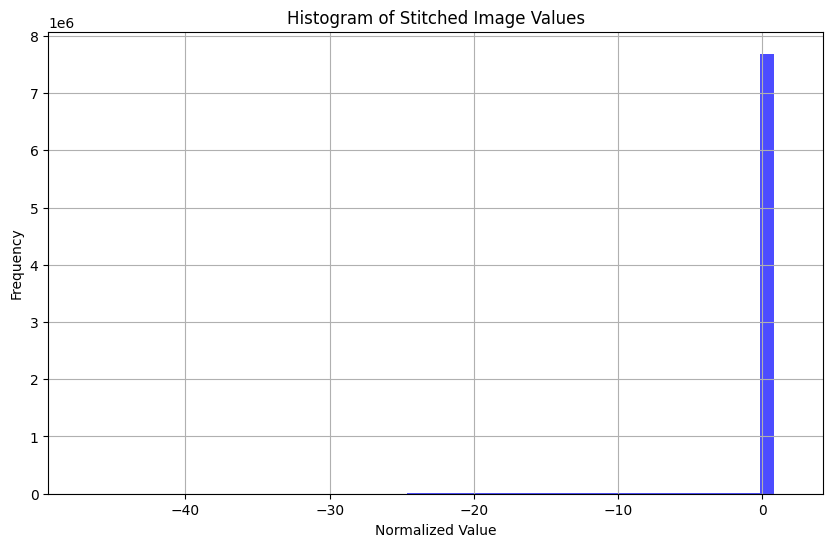

Count of 0 values: 7682452
Count of non-zero values: 262144


In [60]:
import matplotlib.pyplot as plt

# Plot the stitched image
plt.figure(figsize=(10, 6))
plt.imshow(stitched, cmap='viridis')
plt.colorbar(label='Normalized Value')
plt.title('Stitched Image')
plt.xlabel('Pixel X Coordinate')
plt.ylabel('Pixel Y Coordinate')
plt.show()

# Plot a histogram of the stitched image values
plt.figure(figsize=(10, 6))
plt.hist(stitched.ravel(), bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Stitched Image Values')
plt.xlabel('Normalized Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Count of 0 and non-zero values in the stitched image
zero_vals = np.sum(stitched == 0)
non_zero_vals = np.sum(stitched != 0)

print(f"Count of 0 values: {zero_vals}")
print(f"Count of non-zero values: {non_zero_vals}")



In [56]:

template[list(stacked_ds.data_vars)[0]].values = np.expand_dims(stitched, axis=0)

In [57]:
# Save the modified template as a .nc file
output_filename = "processed_data.nc"
template.to_netcdf(output_filename)
print(f"Data saved to {output_filename}")


Data saved to processed_data.nc
